In [1]:

%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

import vis

from catboost import Pool, CatBoostClassifier


# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.metrics import auc

from scipy import interp

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
train = pd.read_csv('../input/application_train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [3]:
test = pd.read_csv('../input/application_test.csv')

In [4]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,...,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,0.2759,...,0.3081,0.1974,0.9970,0.9597,0.1173,0.32,0.2759,0.375,0.0417,0.2078,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0

In [5]:
le = LabelEncoder()
le_count = 0

for col in train:
    if train[col].dtype == 'object':
        if len(list(train[col].unique())) <= 2:
            le.fit(train[col])
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            le_count += 1


In [6]:
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [7]:
train_df = pd.get_dummies(train)
test_df = pd.get_dummies(test)

In [8]:
print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [9]:
target = train_df['TARGET']

train_df, test_df = train_df.align(test_df, join='inner', axis=1)

train_df['TARGET'] = target

In [10]:
print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [11]:
train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
test_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [12]:
train_df['CREDIT_INCOME_PERCENT'] = train_df['AMT_CREDIT'] / train_df['AMT_INCOME_TOTAL']
train_df['ANNUITY_INCOME_PERCENT'] = train_df['AMT_ANNUITY'] / train_df['AMT_INCOME_TOTAL']
train_df['CREDIT_TERM'] = train_df['AMT_ANNUITY'] / train_df['AMT_CREDIT']
train_df['DAYS_EMPLOYED_PERCENT'] = train_df['DAYS_EMPLOYED'] / train_df['DAYS_BIRTH']

In [13]:
test_df['CREDIT_INCOME_PERCENT'] = test_df['AMT_CREDIT'] / test_df['AMT_INCOME_TOTAL']
test_df['ANNUITY_INCOME_PERCENT'] = test_df['AMT_ANNUITY'] / test_df['AMT_INCOME_TOTAL']
test_df['CREDIT_TERM'] = test_df['AMT_ANNUITY'] / test_df['AMT_CREDIT']
test_df['DAYS_EMPLOYED_PERCENT'] = test_df['DAYS_EMPLOYED'] / test_df['DAYS_BIRTH']

In [14]:
if 'TARGET' in train_df:
    y_train = train_df['TARGET']
    X_train = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
else:
    X_train = train_df.copy()

features = X_train.columns.tolist()

X_test = test_df.drop(columns=['SK_ID_CURR']).copy()


In [15]:
print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (307511, 242)
Testing data shape:  (48744, 242)


In [16]:
cat_features = np.where(X_train.dtypes != np.float)[0]

In [17]:
cat_features

array([  0,   1,   2,   3,   9,  12,  14,  15,  16,  17,  18,  19,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237])

In [18]:
X_train.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,...,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,2.007889,0.121978,0.060749,0.067329
1,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,4.790750,0.132217,0.027598,0.070862
2,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.000000,0.100000,0.050000,0.011814
3,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.316167,0.219900,0.094941,0.159905
4,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [19]:
folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1)


In [20]:

cat = CatBoostClassifier(learning_rate=0.01,
                          n_estimators=1000,
                          custom_loss='CrossEntropy',
                          random_state=0
#                           max_depth=5
                         )

In [21]:
import re
X_train_copy = X_train.copy()
X_train_copy = X_train_copy.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '',x))

In [22]:
X_train_copy.shape

(307511, 242)

In [23]:
X_test = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '',x))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6821034	test: 0.6821153	best: 0.6821153 (0)	total: 161ms	remaining: 2m 41s
50:	learn: 0.3868944	test: 0.3872928	best: 0.3872928 (50)	total: 3.84s	remaining: 1m 11s
100:	learn: 0.3010062	test: 0.3016316	best: 0.3016316 (100)	total: 7.54s	remaining: 1m 7s
150:	learn: 0.2726968	test: 0.2735161	best: 0.2735161 (150)	total: 11.4s	remaining: 1m 4s
200:	learn: 0.2613071	test: 0.2623289	best: 0.2623289 (200)	total: 15.6s	remaining: 1m 2s
250:	learn: 0.2559490	test: 0.2571900	best: 0.2571900 (250)	total: 19.8s	remaining: 59.2s
300:	learn: 0.2530190	test: 0.2544253	best: 0.2544253 (300)	total: 24.2s	remaining: 56.2s
350:	learn: 0.2512645	test: 0.2528673	best: 0.2528673 (350)	total: 28.3s	remaining: 52.4s
400:	learn: 0.2500290	test: 0.2518370	best: 0.2518370 (400)	total: 32.6s	remaining: 48.7s
450:	learn: 0.2490754	test: 0.2510732	best: 0.2510732 (450)	total: 36.7s	remaining: 44.7s
500:	learn: 0.2482922	test: 0.2504512	best: 0.2504512 (500)	total: 41s	remaining: 40.8s
550:	learn: 0.24

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6824111	test: 0.6823945	best: 0.6823945 (0)	total: 80.2ms	remaining: 1m 20s
50:	learn: 0.3868797	test: 0.3867928	best: 0.3867928 (50)	total: 3.38s	remaining: 1m 2s
100:	learn: 0.3013670	test: 0.3014101	best: 0.3014101 (100)	total: 7.05s	remaining: 1m 2s
150:	learn: 0.2725645	test: 0.2727894	best: 0.2727894 (150)	total: 11.2s	remaining: 1m 3s
200:	learn: 0.2610512	test: 0.2614814	best: 0.2614814 (200)	total: 15.6s	remaining: 1m 1s
250:	learn: 0.2558355	test: 0.2564293	best: 0.2564293 (250)	total: 19.9s	remaining: 59.3s
300:	learn: 0.2529202	test: 0.2536826	best: 0.2536826 (300)	total: 24.2s	remaining: 56.2s
350:	learn: 0.2512094	test: 0.2521258	best: 0.2521258 (350)	total: 28.5s	remaining: 52.8s
400:	learn: 0.2499820	test: 0.2510591	best: 0.2510591 (400)	total: 32.8s	remaining: 49s
450:	learn: 0.2491107	test: 0.2503067	best: 0.2503067 (450)	total: 37.1s	remaining: 45.2s
500:	learn: 0.2484089	test: 0.2497401	best: 0.2497401 (500)	total: 41.5s	remaining: 41.3s
550:	learn: 0.24

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6825224	test: 0.6825104	best: 0.6825104 (0)	total: 179ms	remaining: 2m 59s
50:	learn: 0.3862281	test: 0.3861838	best: 0.3861838 (50)	total: 4.24s	remaining: 1m 18s
100:	learn: 0.3011577	test: 0.3012646	best: 0.3012646 (100)	total: 7.96s	remaining: 1m 10s
150:	learn: 0.2723815	test: 0.2727452	best: 0.2727452 (150)	total: 12.3s	remaining: 1m 9s
200:	learn: 0.2610503	test: 0.2616254	best: 0.2616254 (200)	total: 16.7s	remaining: 1m 6s
250:	learn: 0.2559056	test: 0.2567283	best: 0.2567283 (250)	total: 21s	remaining: 1m 2s
300:	learn: 0.2530136	test: 0.2540332	best: 0.2540332 (300)	total: 25.4s	remaining: 59s
350:	learn: 0.2512220	test: 0.2524524	best: 0.2524524 (350)	total: 29.8s	remaining: 55.1s
400:	learn: 0.2500291	test: 0.2514305	best: 0.2514305 (400)	total: 34.1s	remaining: 51s
450:	learn: 0.2491613	test: 0.2507474	best: 0.2507474 (450)	total: 38.5s	remaining: 46.8s
500:	learn: 0.2484209	test: 0.2501817	best: 0.2501817 (500)	total: 42.7s	remaining: 42.6s
550:	learn: 0.24780

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6823883	test: 0.6823945	best: 0.6823945 (0)	total: 90.8ms	remaining: 1m 30s
50:	learn: 0.3867870	test: 0.3867100	best: 0.3867100 (50)	total: 3.73s	remaining: 1m 9s
100:	learn: 0.3012317	test: 0.3008553	best: 0.3008553 (100)	total: 7.67s	remaining: 1m 8s
150:	learn: 0.2730077	test: 0.2723056	best: 0.2723056 (150)	total: 11.7s	remaining: 1m 5s
200:	learn: 0.2616897	test: 0.2606492	best: 0.2606492 (200)	total: 16s	remaining: 1m 3s
250:	learn: 0.2564721	test: 0.2551421	best: 0.2551421 (250)	total: 20.4s	remaining: 1m
300:	learn: 0.2537258	test: 0.2522707	best: 0.2522707 (300)	total: 24.7s	remaining: 57.4s
350:	learn: 0.2520451	test: 0.2505054	best: 0.2505054 (350)	total: 29.1s	remaining: 53.8s
400:	learn: 0.2508941	test: 0.2493460	best: 0.2493460 (400)	total: 33.6s	remaining: 50.1s
450:	learn: 0.2500304	test: 0.2484896	best: 0.2484896 (450)	total: 38.1s	remaining: 46.4s
500:	learn: 0.2493182	test: 0.2478193	best: 0.2478193 (500)	total: 42.9s	remaining: 42.7s
550:	learn: 0.24875

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6825234	test: 0.6825367	best: 0.6825367 (0)	total: 98.7ms	remaining: 1m 38s
50:	learn: 0.3863576	test: 0.3866143	best: 0.3866143 (50)	total: 3.7s	remaining: 1m 8s
100:	learn: 0.3005368	test: 0.3010226	best: 0.3010226 (100)	total: 7.78s	remaining: 1m 9s
150:	learn: 0.2723226	test: 0.2731107	best: 0.2731107 (150)	total: 11.7s	remaining: 1m 5s
200:	learn: 0.2609354	test: 0.2620244	best: 0.2620244 (200)	total: 16.1s	remaining: 1m 4s
250:	learn: 0.2558700	test: 0.2572342	best: 0.2572342 (250)	total: 20.4s	remaining: 1m
300:	learn: 0.2530087	test: 0.2546529	best: 0.2546529 (300)	total: 24.7s	remaining: 57.4s
350:	learn: 0.2512586	test: 0.2531263	best: 0.2531263 (350)	total: 29s	remaining: 53.6s
400:	learn: 0.2499457	test: 0.2520507	best: 0.2520507 (400)	total: 33.5s	remaining: 50s
450:	learn: 0.2490103	test: 0.2513069	best: 0.2513069 (450)	total: 38.9s	remaining: 47.4s
500:	learn: 0.2483195	test: 0.2508003	best: 0.2508003 (500)	total: 43.1s	remaining: 43s
550:	learn: 0.2477501	te

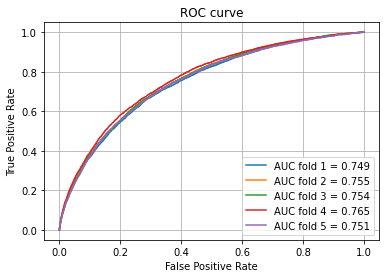

In [24]:
full_auc = []
test_preds = np.zeros(X_test.shape[0])
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train_copy, y_train)):
    X_tra, y_tra = X_train_copy.iloc[train_idx], y_train.iloc[train_idx]
    X_valid, y_valid = X_train_copy.iloc[valid_idx], y_train.iloc[valid_idx]
#     positive_count = y_tra.sum()
    
#     rus = RandomUnderSampler(random_state=1,
#                              sampling_strategy={0:positive_count*10, 1:positive_count})
#     X_train_re, y_train_re = rus.fit_resample(X_tra, y_tra)
    X_tra, X_val, y_tra, y_val=train_test_split(X_tra, y_tra, test_size=0.2, random_state=1, stratify=y_tra)
    train_pool = Pool(X_tra, y_tra, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
    pred = cat.fit(train_pool,
                    eval_set=valid_pool,
                    verbose=50,
                    early_stopping_rounds=100,
#                     eval_metric='auc',
                    plot=True).predict_proba(X_valid)[:, 1]
#     auc_score = roc_auc_score(y_valid, pred)
    fpr, tpr, thresholds = roc_curve(y_valid, pred)
    auc_score = roc_auc_score(y_valid, pred)
    
    full_auc.append(auc_score)
    
    #predict test data
    test_preds += cat.predict(X_test, prediction_type='Probability')[:,1]/folds.n_splits
    plt.plot(fpr, tpr, label='AUC fold %d = %.3f' % (n_fold+1, auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()
    

In [25]:
np.mean(full_auc)

0.7548029506835057

In [42]:
pred = cat.predict_proba(X_test)[:,1]

In [43]:
submit_df = pd.DataFrame({'SK_ID_CURR':test_df.SK_ID_CURR, 'TARGET':pred})

In [44]:
submit_df.head()

,SK_ID_CURR,TARGET
0,100001,0.060611
1,100005,0.108355
2,100013,0.027919
3,100028,0.031379
4,100038,0.140544


In [45]:
submit_df.to_csv('baseline_catboost.csv', index=False)